In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

C:\Users\antho\Anaconda3\lib\site-packages\backtesting\_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [4]:
import scipy.interpolate as interp
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [5]:
sp_df = yf.download('^GSPC', 
                      start='2011-09-13', 
                      end='2019-12-13', 
                      progress=False,interval='1d')
ohlc = sp_df.iloc[:,:4]
ohlc

,Open,High,Low,Close
Date,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010
...,...,...,...,...
2019-12-06,3134.620117,3150.600098,3134.620117,3145.909912
2019-12-09,3141.860107,3148.870117,3135.459961,3135.959961
2019-12-10,3135.360107,3142.120117,3126.090088,3132.520020


In [6]:
yr1 = ohlc.loc['2018-12-12':]
yr2 = ohlc.loc['2017-12-12':]
yr4 = ohlc.loc['2015-12-12':]

# Strategies

In [7]:
def SMA(values,n):
    return pd.Series(values).rolling(n).mean()

In [8]:
class SmaCross(Strategy):
    
    n1 = 1
    n2 = 21
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [9]:
def EMA(val,n):
    res = pd.Series(val).copy()
    return res.ewm(span=n,adjust=False).mean()

In [10]:
class EmaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [11]:
def DEMA(val,n):
    exp1 = EMA(val,n)
    exp2 = EMA(exp1,n)
    return 2*exp1 - exp2

In [12]:
class DemaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

# Strategies for Time Horizons

In [13]:
def time_horiz(hist,ma):
    
    if ma == 'SMA':
        bt = Backtest(hist,SmaCross,cash=10000)
    elif ma == 'EMA':
        bt = Backtest(hist,EmaCross,cash=10000)
    elif ma == 'DEMA':
        bt = Backtest(hist,DemaCross,cash=10000)
    
    data, heat = bt.optimize('Sharpe Ratio',n1=range(2,50,2),n2=range(2,50,2),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

    heat.sort_values()
    hmap = heat.groupby(['n1','n2']).mean().unstack()
    hmap

    heat_pic = sns.heatmap(hmap, cmap='Spectral')
    
    tr = hmap.stack()

    n1 = [i[0] for i in tr.index]
    n2 = [i[1] for i in tr.index]

    val = []
    for (i,j) in zip(n1,n2):
        if i<j:
            val.append(tr.loc[i,j])

    px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),100),np.linspace(np.min(n2),np.max(n2),100))
    pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(px,py,pz,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
    return data

# 1 Year SMA

In [13]:
bt = Backtest(yr1,SmaCross,cash=10000)
data, heat = bt.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


In [15]:
data

Start                      2018-12-12 00:00:00
End                        2019-12-12 00:00:00
Duration                     365 days 00:00:00
Exposure [%]                           74.5205
Equity Final [$]                       11509.1
Equity Peak [$]                        11571.4
Return [%]                             15.0914
Buy & Hold Return [%]                  19.5204
Max. Drawdown [%]                     -4.10948
Avg. Drawdown [%]                     -1.44494
Max. Drawdown Duration        49 days 00:00:00
Avg. Drawdown Duration        12 days 00:00:00
# Trades                                    11
Win Rate [%]                           72.7273
Best Trade [%]                         4.64204
Worst Trade [%]                       -2.08019
Avg. Trade [%]                         1.15575
Max. Trade Duration           55 days 00:00:00
Avg. Trade Duration           25 days 00:00:00
Expectancy [%]                         1.67201
SQN                                    1.90377
Sharpe Ratio 

In [94]:
heat.index.names = [r'Short (days)',r'Long (days)']

In [102]:
hh = heat*np.sqrt(12)

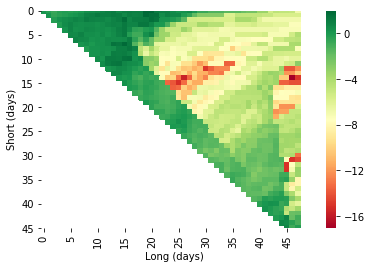

In [103]:
hh.sort_values()
hmap_sma = hh.groupby([r'Short (days)',r'Long (days)']).mean().unstack()
ax = sns.heatmap(hmap_sma,cmap='RdYlGn',xticklabels=list(range(0,50)),yticklabels=list(range(0,50)))
ax.set_xticks(ax.get_xticks()[::5])
ax.set_xticklabels(list(range(0,50))[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_yticklabels(list(range(0,50))[::5])
fig = ax.get_figure()

In [105]:
fig.tight_layout()
fig.savefig('sp_sma1_hmap.png')

In [15]:
rr = bt.run()._trade_data
rr['P/L'].iloc[0] = 0
rr['P/L'] = rr['P/L'].interpolate(method='time')

C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


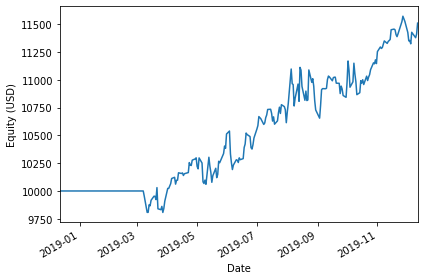

In [100]:
plt.xlabel('Date')
plt.ylabel(r'Equity (USD)')
fig = rr['Equity'].plot().get_figure()
fig.tight_layout()
fig.savefig('sp_sma1_equity.png')

In [62]:
class SmaCross_alt(Strategy):
    
    n1 = 40
    n2 = 43
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [63]:
alt_max = Backtest(yr1,SmaCross_alt,cash=10000).run()._trade_data
alt_max['P/L'].iloc[0] = 0
alt_max['P/L'] = alt_max['P/L'].interpolate(method='time')

C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


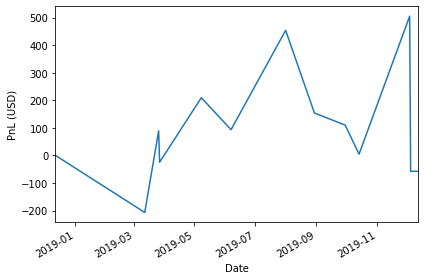

In [16]:
plt.xlabel('Date')
plt.ylabel(r'PnL (USD)')
fig = rr['P/L'].plot().get_figure()
fig.tight_layout()
fig.savefig('sp_sma1_pl.png')

# 1 Year EMA

In [149]:
ema1 = Backtest(yr1,EmaCross,cash=10000)
d_ema1, heat_ema1 = ema1.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


In [150]:
d_ema1

Start                      2018-12-12 00:00:00
End                        2019-12-12 00:00:00
Duration                     365 days 00:00:00
Exposure [%]                           76.1644
Equity Final [$]                         12175
Equity Peak [$]                          12175
Return [%]                             21.7504
Buy & Hold Return [%]                  19.5204
Max. Drawdown [%]                     -4.88741
Avg. Drawdown [%]                     -1.31528
Max. Drawdown Duration        63 days 00:00:00
Avg. Drawdown Duration        13 days 00:00:00
# Trades                                     8
Win Rate [%]                                75
Best Trade [%]                         6.48405
Worst Trade [%]                       -1.46501
Avg. Trade [%]                          1.6676
Max. Trade Duration           61 days 00:00:00
Avg. Trade Duration           35 days 00:00:00
Expectancy [%]                         2.08785
SQN                                     1.9738
Sharpe Ratio 

In [153]:
heat_ema1.index.names = [r'Short (days)',r'Long (days)']
hh_ema = heat_ema1*np.sqrt(12)

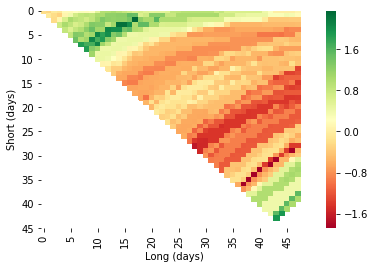

In [154]:
hh_ema.sort_values()
hmap_ema = hh_ema.groupby([r'Short (days)',r'Long (days)']).mean().unstack()
ax = sns.heatmap(hmap_ema,cmap='RdYlGn',xticklabels=list(range(0,50)),yticklabels=list(range(0,50)))
ax.set_xticks(ax.get_xticks()[::5])
ax.set_xticklabels(list(range(0,50))[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_yticklabels(list(range(0,50))[::5])
fig = ax.get_figure()

In [155]:
fig.tight_layout()
fig.savefig('sp_ema1_hmap.png')

# 1 Year DEMA

In [151]:
dema1 = Backtest(yr1,DemaCross,cash=10000)
d_dema1, heat_dema1 = dema1.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


In [152]:
d_dema1

Start                        2018-12-12 00:00:00
End                          2019-12-12 00:00:00
Duration                       365 days 00:00:00
Exposure [%]                              90.137
Equity Final [$]                         11761.8
Equity Peak [$]                          12207.8
Return [%]                               17.6183
Buy & Hold Return [%]                    19.5204
Max. Drawdown [%]                       -5.88911
Avg. Drawdown [%]                       -1.84022
Max. Drawdown Duration          66 days 00:00:00
Avg. Drawdown Duration          17 days 00:00:00
# Trades                                       9
Win Rate [%]                             77.7778
Best Trade [%]                           8.13436
Worst Trade [%]                         -2.98032
Avg. Trade [%]                           2.10524
Max. Trade Duration             56 days 00:00:00
Avg. Trade Duration             37 days 00:00:00
Expectancy [%]                           2.89292
SQN                 

In [156]:
heat_dema1.index.names = [r'Short (days)',r'Long (days)']
hh_dema = heat_dema1*np.sqrt(12)

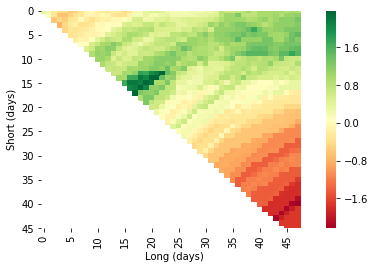

In [157]:
hh_dema.sort_values()
hmap_dema = hh_dema.groupby([r'Short (days)',r'Long (days)']).mean().unstack()
ax = sns.heatmap(hmap_dema,cmap='RdYlGn',xticklabels=list(range(0,50)),yticklabels=list(range(0,50)))
ax.set_xticks(ax.get_xticks()[::5])
ax.set_xticklabels(list(range(0,50))[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_yticklabels(list(range(0,50))[::5])
fig = ax.get_figure()

In [158]:
fig.tight_layout()
fig.savefig('sp_dema1_hmap.png')

# 2 Year SMA

In [106]:
sma2 = Backtest(yr2,SmaCross,cash=10000)
d_sma2, h_sma2 = sma2.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


# 2 Year EMA

In [107]:
ema2 = Backtest(yr2,EmaCross,cash=10000)
d_ema2, h_ema2 = ema2.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


# 2 Year DEMA

In [108]:
dema2 = Backtest(yr2,DemaCross,cash=10000)
d_dema2, h_dema2 = dema2.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


# 4 Year SMA

In [109]:
sma4 = Backtest(yr4,SmaCross,cash=10000)
d_sma4, h_sma4 = sma4.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


# 4 Year EMA

In [110]:
ema4 = Backtest(yr4,EmaCross,cash=10000)
d_ema4, h_ema4 = ema4.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


# 4 Year DEMA

In [111]:
dema4 = Backtest(yr4,DemaCross,cash=10000)
d_dema4, h_dema4 = dema4.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


# Whole Dataset

In [112]:
smaw = Backtest(ohlc,SmaCross,cash=10000)
d_smaw, h_smaw = smaw.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


In [113]:
emaw = Backtest(ohlc,EmaCross,cash=10000)
d_emaw, h_emaw = emaw.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


In [114]:
demaw = Backtest(ohlc,DemaCross,cash=10000)
d_demaw, h_demaw = demaw.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


In [117]:
d_emaw

Start                       2011-09-12 00:00:00
End                         2019-12-12 00:00:00
Duration                     3013 days 00:00:00
Exposure [%]                            96.1832
Equity Final [$]                        14965.4
Equity Peak [$]                         16512.8
Return [%]                               49.654
Buy & Hold Return [%]                   172.619
Max. Drawdown [%]                      -20.1087
Avg. Drawdown [%]                      -2.30397
Max. Drawdown Duration       1167 days 00:00:00
Avg. Drawdown Duration         52 days 00:00:00
# Trades                                     25
Win Rate [%]                                 44
Best Trade [%]                          32.8437
Worst Trade [%]                        -6.51226
Avg. Trade [%]                          1.70828
Max. Trade Duration           664 days 00:00:00
Avg. Trade Duration           116 days 00:00:00
Expectancy [%]                          5.11367
SQN                                    0

In [147]:
d_demaw

Start                        2011-09-12 00:00:00
End                          2019-12-12 00:00:00
Duration                      3013 days 00:00:00
Exposure [%]                             99.2698
Equity Final [$]                         10375.1
Equity Peak [$]                          11631.6
Return [%]                               3.75085
Buy & Hold Return [%]                    172.619
Max. Drawdown [%]                       -22.6104
Avg. Drawdown [%]                       -3.81429
Max. Drawdown Duration        2481 days 00:00:00
Avg. Drawdown Duration         199 days 00:00:00
# Trades                                     122
Win Rate [%]                             36.0656
Best Trade [%]                           8.18206
Worst Trade [%]                         -5.33635
Avg. Trade [%]                         0.0787083
Max. Trade Duration             84 days 00:00:00
Avg. Trade Duration             25 days 00:00:00
Expectancy [%]                           2.06948
SQN                 

In [148]:
0.0282968*np.sqrt(12)

0.09802299058323001